In [51]:
import os
import glob
import pickle
import time
from math import log2
from itertools import cycle, product
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
%matplotlib inline

# Aspect ratio and height of subplots
ASPECT = 4. / 3.
HEIGHT = 3.
HEIGHT_LARGE = 4.
LEGEND_FONTSIZE = "x-small"
LEGEND_LOC = "upper right"

In [52]:
def as_power_of_2(num):
    return "2**" + str(int(log2(float(num))))

# Settings

In [62]:
# Data logs root directory
LOG_DIR = "../logs/logs1"
PLOT_DIR = "plots1"
# Loss function: either "logistic" regression, or nonlinear least squares ('nllsq')
LOSSES = ("logistic", "nllsq")
# The following should be the same as the one used in run_experiment.py
DATASETS = ("w8a", "rcv1", "real-sim",)
OPTIMIZERS = ("SGD", "SARAH", "L-SVRG", "Adam")
MAX_EPOCHS = 100  # Use 2xT used in run_experiment.py
# These are the metrics collected in the data logs
METRICS = ("loss", "gradnorm", "error")
# These are aggregators for comparing multi-seed runs
AGGS = ("mean", "median")
# These are the logs columns: effective passes + metrics + walltime
LOG_COLS = ["ep", "loss", "gradnorm", "error", "time"]
DATA_INDICES = [0, 1, 2, 3, 6]  # indices corresponding to chosen cols in logs
# These are the hyperparameters of interest
ARG_COLS = ["lr", "alpha", "beta2", "precond"]


class Args:
    # Choose loss, metric, and aggregation method
    idx = "time"
    loss = "logistic"
    metric = "error"
    agg = "mean"
    # Downsample this number of effective passes by averaging them
    avg_downsample = 5
    # Logs will be filtered for this setting when applicable (USE EXACT STRING VALUE AS IN FILENAME).
    filter_args = {
        "corrupt": "none",
        "beta1": '0.0',
    }
    # Ignore all runs containing 'any' of these hyperparams.
    ignore_args = {
        "alpha": (1e-11,),
        "weight_decay": (0.1,),
    }
    # Force remove log files that are empty
    remove_empty_file = False

    def __init__(self, log_dir, plot_dir) -> None:
        self.log_dir = log_dir
        self.log_dir = os.path.join(self.log_dir, self.loss)
        self.plots_dir = plot_dir
        os.makedirs(self.plots_dir, exist_ok=True)
        self.as_dict = dict(idx=self.idx, loss=self.loss, metric=self.metric, **self.filter_args)
        self.experiment_str = f"_".join(f"{k}_{v}" for k,v in self.as_dict.items())

    def __repr__(self) -> str:
        experiment_repr = f", ".join(f"{k}={v}" for k,v in self.as_dict.items())
        return f"Args({experiment_repr})"


args = Args(log_dir=LOG_DIR, plot_dir=PLOT_DIR)

### Utility functions for loading data

In [54]:
def ignore(args, args_dict):
    return any(args_dict[arg] in map(str, args.ignore_args[arg])
               for arg in args.ignore_args.keys() if arg in args_dict)


def loaddata(fname):
    with open(fname, 'rb') as f:
        data = pickle.load(f)
    return data


def contain_dict(dict1, dict2):
    return all(dict1[k] == v for k, v in dict2.items() if k in dict1)

# Gathering data and finding best hyperparameters for each (optimizer, dataset) combination

In [55]:
def unpack_args(fname):
    """
    Recover all args given file path.
    """
    # unpack path
    dirname, logname = os.path.split(fname)
    logdir, dataset = os.path.split(dirname)
    optimizer, log_args = logname.split("(")
    log_args, _ = log_args.split(")")  # e.g. remove ').pkl'
    args_dict = {k:v for k,v in [s.split("=") for s in log_args.split(",")]}

    args_dict["dataset"] = dataset
    args_dict["optimizer"] = optimizer

    # It is very unlikely that the original dataset name will end with ')'
    args_dict["corrupt"] = dataset[dataset.index("("):] if dataset[-1] == ")" else "none"

    # Set to default values if field does not exists
    if "seed" not in args_dict:
        args_dict["seed"] = '0'
    if "weight_decay" not in args_dict:
        args_dict["weight_decay"] = '0.0'
    if "lr_decay" not in args_dict:
        args_dict["lr_decay"] = '0.0'
    if "precond" not in args_dict:  # these are reserved for precond algs
        args_dict["precond"] = "none"
        args_dict["alpha"] = "none"
        args_dict["beta2"] = "none"
    # if "beta1" not in args_dict:
    #     args_dict["beta1"] = '0.0'
    
    # XXX: only Adam has beta1 = 0.9, it is 0 otherwise
    # if optimizer == "Adam":
    #     has_mom = args_dict["beta1"] == '0.9'
    #     args_dict["optimizer"] = "Adam_momentum" if has_mom else "Adam_no_momentum"
    # del args_dict["beta1"]

    return args_dict


def handle_empty_file(args, fname):
    print(fname, "has no data!")
    if not args.remove_empty_files:
        if "y" == input("Remove empty log files in the future without asking? y/(n)"):
            print("Will remove without asking.")
            args.remove_empty_files = True
        else:
            print("Will ask again before removing.")
    else:
        try:
            print("Removing", fname)
            os.remove(fname)
        except OSError as e:
            print ("Error: %s - %s." % (e.filename, e.strerror))


def get_logs(logdir, dataset, optimizer, **filter_args):
    """
    Return all logs in 'logdir' containing the filter hyperparams.
    Dataset name should contain feature scaling, if any
    e.g. 'dataset' or 'dataset(k_min,k_max)'.
    
    Returns the data in the log file and its arguments/hyperparams.
    """
    if "corrupt" in filter_args and filter_args['corrupt'] != "none":
        # Add scale suffix to specify dataset    
        dataset += filter_args['corrupt']
    else:
        # No setting specified, use wildcard to match all suffixes
        dataset += "*"

    # Find all files matching this pattern
    for fname in glob.glob(f"{logdir}/{dataset}/{optimizer}(*).pkl"):
        exp_args = unpack_args(fname)
        # Skip if filter_args does not match args of this file
        if not contain_dict(exp_args, filter_args):
            continue
        data = loaddata(fname)
        if len(data) == 0:
            handle_empty_file(args, fname)
            continue

        yield data, exp_args


def downsample_dataframe(args, df, downsample_idx="ep"):
    # Downsample by averaging metrics every 'avg_downsample' epoch.
    df[downsample_idx] = np.ceil(df[downsample_idx] / args.avg_downsample) * args.avg_downsample
    df = df.groupby([downsample_idx] + ARG_COLS).mean().reset_index()
    return df


def create_experiments_dataframe(args):
    # Gather data
    all_dfs = {}
    start_time = time.time()
    for experiment in product(DATASETS, OPTIMIZERS):
        dataset, optimizer = experiment
        exp_dfs = []
        # Get all log data given the experiment and filter args
        for data, args_dict in get_logs(args.log_dir, dataset, optimizer, **args.filter_args):
            if ignore(args, args_dict):
                continue
            # Get experiment log data
            df = pd.DataFrame(data[:, DATA_INDICES], columns=LOG_COLS)
            # Get args of interest
            for col in ARG_COLS:
                df[col] = args_dict[col]
            df = downsample_dataframe(args, df, "ep")
            df = df[df["ep"] <= MAX_EPOCHS]  # cut data up to the prespecified epoch T
            exp_dfs.append(df)

        # Record all runs of exp in a single dataframe
        all_dfs[experiment] = pd.concat(exp_dfs, ignore_index=True)
        if len(exp_dfs) == 0:
            print(f"No log data found! Experiment = {experiment}, filter args = {args.filter_args}")
            continue

    data_gather_time = time.time() - start_time
    print(f"Data frame lengths:")
    for exp, df in all_dfs.items():
        print(f"{exp} -> {len(df)} data rows -> {len(df) // MAX_EPOCHS} runs")
    print(f"Took about {data_gather_time:.2f} seconds to gather all these data.")

    return all_dfs


all_dfs = create_experiments_dataframe(args)

Data frame lengths:
('w8a', 'SGD') -> 36960 data rows -> 369 runs
('w8a', 'SARAH') -> 36960 data rows -> 369 runs
('w8a', 'L-SVRG') -> 36960 data rows -> 369 runs
('w8a', 'Adam') -> 9240 data rows -> 92 runs
('rcv1', 'SGD') -> 36960 data rows -> 369 runs
('rcv1', 'SARAH') -> 36960 data rows -> 369 runs
('rcv1', 'L-SVRG') -> 36960 data rows -> 369 runs
('rcv1', 'Adam') -> 9240 data rows -> 92 runs
('real-sim', 'SGD') -> 36960 data rows -> 369 runs
('real-sim', 'SARAH') -> 36960 data rows -> 369 runs
('real-sim', 'L-SVRG') -> 36960 data rows -> 369 runs
('real-sim', 'Adam') -> 9240 data rows -> 92 runs
Took about 62.00 seconds to gather all these data.


In [71]:
################ XXX
# Get min time for each dataset then cut runs up to that point
min_last_idx = {dataset: float('inf') for dataset in DATASETS}
for experiment in product(DATASETS, OPTIMIZERS):
    dataset, _ = experiment
    df = all_dfs[experiment]
    indices = df[args.idx]
    # df = df[df[args.idx] > 30]
    display(experiment)
    display(indices.max())
    # display(df)
    min_last_idx[dataset] = min(min_last_idx[dataset], indices.max())

for experiment in product(DATASETS, OPTIMIZERS):
    dataset, _ = experiment
    df = all_dfs[experiment]
    df = df[df[args.idx] <= min_last_idx[dataset]]
    # all_dfs[experiment] = df

('w8a', 'SGD')

91.0659101208051

('w8a', 'SARAH')

35.27804293235143

('w8a', 'L-SVRG')

40.588307897249855

('w8a', 'Adam')

40.25101218620936

('rcv1', 'SGD')

456.46711833953856

('rcv1', 'SARAH')

1549.5161167658293

('rcv1', 'L-SVRG')

128.09289513315474

('rcv1', 'Adam')

213.2977029132843

('real-sim', 'SGD')

447.3829149206479

('real-sim', 'SARAH')

2103.05823115869

('real-sim', 'L-SVRG')

124.95830607414246

('real-sim', 'Adam')

201.38843316833177

('w8a', 'SGD') 35.27804293235143
('w8a', 'SARAH') 35.27804293235143
('w8a', 'L-SVRG') 35.27804293235143
('w8a', 'Adam') 35.27804293235143
('rcv1', 'SGD') 128.09289513315474
('rcv1', 'SARAH') 128.09289513315474
('rcv1', 'L-SVRG') 128.09289513315474
('rcv1', 'Adam') 128.09289513315474
('real-sim', 'SGD') 124.95830607414246
('real-sim', 'SARAH') 124.95830607414246
('real-sim', 'L-SVRG') 124.95830607414246
('real-sim', 'Adam') 124.95830607414246


In [7]:
for i, (exp, df) in enumerate(all_dfs.items()):
    if i == 4: break
    print(exp)
    display(df)

('w8a', 'SGD')


ep               lr alpha  beta2     precond      loss  gradnorm  \
0        0.0             0.25  none   none        none  0.693147  0.022024   
1        5.0             0.25  none   none        none  0.232852  0.001539   
2       10.0             0.25  none   none        none  0.157726  0.000032   
3       15.0             0.25  none   none        none  0.147243  0.000015   
4       20.0             0.25  none   none        none  0.141347  0.000010   
...      ...              ...   ...    ...         ...       ...       ...   
36955   80.0  6.103515625e-05   0.1  0.995  hutchinson  0.539378  0.012514   
36956   85.0  6.103515625e-05   0.1  0.995  hutchinson  0.532151  0.012096   
36957   90.0  6.103515625e-05   0.1  0.995  hutchinson  0.524894  0.011680   
36958   95.0  6.103515625e-05   0.1  0.995  hutchinson  0.518161  0.011298   
36959  100.0  6.103515625e-05   0.1  0.995  hutchinson  0.511876  0.010945   

          error       time  
0      0.500000   0.032335  
1      0.067066   0.853871  
2      0.066847   2.522321  
3      0.065743   4.157281  
4      0.064678   5.807665  
...         ...        ...  
36955  0.067569  10.282121  
36956  0.067551  10.923451  
36957  0.067549  11.585886  
36958  0.067549  12.222427  
36959  0.067549  12.838674  

[36960 rows x 9 columns]

('w8a', 'SARAH')


ep lr alpha beta2     precond      loss      gradnorm     error  \
0        0.0  4  none  none        none  0.693147  2.202439e-02  0.500000   
1        5.0  4  none  none        none  0.181984  1.228814e-03  0.065138   
2       10.0  4  none  none        none  0.126886  2.725754e-06  0.061868   
3       15.0  4  none  none        none  0.119963  1.246342e-06  0.060415   
4       20.0  4  none  none        none  0.116111  7.693413e-07  0.059641   
...      ... ..   ...   ...         ...       ...           ...       ...   
36955   80.0  1   0.1  0.95  hutchinson  0.101997  4.168813e-08  0.054788   
36956   85.0  1   0.1  0.95  hutchinson  0.101748  3.789534e-08  0.054712   
36957   90.0  1   0.1  0.95  hutchinson  0.101513  3.452891e-08  0.054688   
36958   95.0  1   0.1  0.95  hutchinson  0.101291  3.151710e-08  0.054604   
36959  100.0  1   0.1  0.95  hutchinson  0.101101  2.909172e-08  0.054531   

            time  
0       0.011825  
1       0.462719  
2       1.440556  
3       2.552174  
4       3.669831  
...          ...  
36955  18.086674  
36956  19.189316  
36957  20.325999  
36958  21.513872  
36959  22.620447  

[36960 rows x 9 columns]

('w8a', 'L-SVRG')


ep          lr  alpha  beta2     precond       loss  gradnorm  \
0        0.0    0.015625  1e-07   0.95  hutchinson   0.693147  0.022024   
1        5.0    0.015625  1e-07   0.95  hutchinson   3.734380  0.002075   
2       10.0    0.015625  1e-07   0.95  hutchinson  10.501591  0.000011   
3       15.0    0.015625  1e-07   0.95  hutchinson  11.198227  0.000014   
4       20.0    0.015625  1e-07   0.95  hutchinson   9.837067  0.000014   
...      ...         ...    ...    ...         ...        ...       ...   
36955   80.0  0.00390625    0.1  0.995  hutchinson   0.200650  0.000257   
36956   85.0  0.00390625    0.1  0.995  hutchinson   0.197697  0.000232   
36957   90.0  0.00390625    0.1  0.995  hutchinson   0.194433  0.000206   
36958   95.0  0.00390625    0.1  0.995  hutchinson   0.191757  0.000186   
36959  100.0  0.00390625    0.1  0.995  hutchinson   0.189881  0.000173   

          error       time  
0      0.500000   0.077312  
1      0.073625   0.503254  
2      0.065494   1.246595  
3      0.062745   1.791328  
4      0.061847   2.475049  
...         ...        ...  
36955  0.066757   8.753129  
36956  0.066671   9.280633  
36957  0.066642   9.930908  
36958  0.066645  10.527061  
36959  0.066789  10.983763  

[36960 rows x 9 columns]

('w8a', 'Adam')


ep      lr alpha beta2 precond      loss      gradnorm     error  \
0       0.0  0.0625  none  none    none  0.693147  2.202439e-02  0.500000   
1       5.0  0.0625  none  none    none  0.124296  6.605800e-04  0.056155   
2      10.0  0.0625  none  none    none  0.098558  5.656111e-07  0.053738   
3      15.0  0.0625  none  none    none  0.097513  4.937184e-07  0.053343   
4      20.0  0.0625  none  none    none  0.097457  5.100338e-07  0.053225   
...     ...     ...   ...   ...     ...       ...           ...       ...   
9235   80.0       1  none  none    none  0.138709  4.452102e-06  0.057068   
9236   85.0       1  none  none    none  0.138995  7.769748e-06  0.057635   
9237   90.0       1  none  none    none  0.138156  5.504925e-06  0.057118   
9238   95.0       1  none  none    none  0.139413  5.418662e-06  0.057321   
9239  100.0       1  none  none    none  0.138201  5.512403e-06  0.057196   

           time  
0      0.022271  
1      1.094188  
2      3.095701  
3      5.028779  
4      6.856337  
...         ...  
9235  17.219467  
9236  18.422943  
9237  19.620246  
9238  20.797663  
9239  21.959126  

[9240 rows x 9 columns]

## Get best hyperparams

In [8]:
# Find the minimum aggregate metric (based on mean, median, etc.)
def get_best_hyperparams(args, perf):
    if args.agg == "mean":
        agg_perf = perf.groupby(ARG_COLS).mean()
    elif args.agg == "median":
        agg_perf = perf.groupby(ARG_COLS).median()
    # Get the aggregated perf that minimizes the chosen metric
    min_agg_perf = agg_perf[agg_perf[args.metric] == agg_perf.min()[args.metric]]
    return min_agg_perf.index


def find_all_best_hyperparams(args, all_dfs):
    best_dfs = {}
    best_dfs_fixed_args = defaultdict(dict)

    # Find set of possible values for each hp adaptively
    fixed_args = defaultdict(set)
    for (dataset, optimizer), df in all_dfs.items():
        if optimizer.startswith("Adam"):
            continue
        for arg_col in ARG_COLS:
            fixed_args[arg_col] = set(df[arg_col])
        break

    for experiment in product(DATASETS, OPTIMIZERS):
        print("Finding best hyperparams for", experiment)
        # Get last metrics/performance (supposed to be epoch-smoothed for better results)
        exp_df = all_dfs[experiment]
        max_ep = exp_df.groupby(ARG_COLS, sort=False)["ep"].transform(max)
        perf = exp_df[exp_df["ep"] == max_ep].drop("ep", axis=1)

        # Get the data associated with the args of the min aggregated metric
        exp_df = exp_df.set_index(ARG_COLS)
        best_dfs[experiment] = exp_df.loc[get_best_hyperparams(args, perf)]
        for arg_col, arg_set in fixed_args.items():
            best_dfs_fixed_args[arg_col][experiment] = {}
            for arg_value in arg_set:
                best_dfs_fixed_args[arg_col][experiment][arg_value] = \
                    exp_df.loc[get_best_hyperparams(args, perf[perf[arg_col] == arg_value])]

    return best_dfs, best_dfs_fixed_args


best_dfs, best_dfs_fixed_args = find_all_best_hyperparams(args, all_dfs)

Finding best hyperparams for ('w8a', 'SGD')
Finding best hyperparams for ('w8a', 'SARAH')
Finding best hyperparams for ('w8a', 'L-SVRG')
Finding best hyperparams for ('w8a', 'Adam')
Finding best hyperparams for ('rcv1', 'SGD')
Finding best hyperparams for ('rcv1', 'SARAH')
Finding best hyperparams for ('rcv1', 'L-SVRG')
Finding best hyperparams for ('rcv1', 'Adam')
Finding best hyperparams for ('real-sim', 'SGD')
Finding best hyperparams for ('real-sim', 'SARAH')
Finding best hyperparams for ('real-sim', 'L-SVRG')
Finding best hyperparams for ('real-sim', 'Adam')


In [48]:
print("Best hyperparams for each optimizer on each dataset given the following setting:")
print(args.filter_args)
print()
for exp, df in best_dfs.items():
    print(exp)
    for arg, val in zip(ARG_COLS, df.index[0]):
        if arg == "lr":
            val = as_power_of_2(val)
        print(f"- {arg} = {val}")
    print()

Best hyperparams for each optimizer on each dataset given the following setting:
{'corrupt': 'none', 'beta1': '0.0'}

('w8a', 'SGD')
- lr = 2**-10
- alpha = 1e-07
- beta2 = 0.999
- precond = hutchinson

('w8a', 'SARAH')
- lr = 2**-10
- alpha = 1e-07
- beta2 = 0.995
- precond = hutchinson

('w8a', 'L-SVRG')
- lr = 2**-8
- alpha = 1e-07
- beta2 = 0.999
- precond = hutchinson

('w8a', 'Adam')
- lr = 2**-4
- alpha = none
- beta2 = none
- precond = none

('rcv1', 'SGD')
- lr = 2**-2
- alpha = 0.001
- beta2 = 0.95
- precond = hutchinson

('rcv1', 'SARAH')
- lr = 2**-12
- alpha = 1e-07
- beta2 = 0.95
- precond = hutchinson

('rcv1', 'L-SVRG')
- lr = 2**-12
- alpha = 1e-07
- beta2 = 0.95
- precond = hutchinson

('rcv1', 'Adam')
- lr = 2**-4
- alpha = none
- beta2 = none
- precond = none

('real-sim', 'SGD')
- lr = 2**-10
- alpha = 1e-07
- beta2 = avg
- precond = hutchinson

('real-sim', 'SARAH')
- lr = 2**-12
- alpha = 1e-07
- beta2 = 0.995
- precond = hutchinson

('real-sim', 'L-SVRG')
- lr =

# Plotting

In [49]:
print("Types")
for col in df.columns:
    print(col, df[col].dtypes)
print("Learning rates:")
for exp, df in all_dfs.items():
    display(set("2**"+str(int(log2(float(lr)))) for lr in df["lr"]))
    break
print("Range")
for col in df.columns:
    if df[col].dtypes != "object":
        print(f"{col}: ({df[col].min():}, {df[col].max()})")

Types
ep float64
loss float64
gradnorm float64
error float64
time float64
Learning rates:


{'2**-10',
 '2**-12',
 '2**-14',
 '2**-16',
 '2**-2',
 '2**-4',
 '2**-6',
 '2**-8',
 '2**0',
 '2**2',
 '2**4'}

Range
ep: (0.0, 100.0)
loss: (0.09594814035044766, 15350.726609743442)
gradnorm: (3.283134042775158e-08, 0.022024385165051036)
error: (0.05244661534235195, 0.5)
time: (0.005331277847290039, 91.0659101208051)


In [50]:
# # # Set inf values to nan and recheck range
# VERYBIGNUMBER = 10**10
# df[df == float("inf")] = np.nan
# df[df[["loss","gradnorm"]] > VERYBIGNUMBER] = np.nan
# for col in df.columns:
#     if df[col].dtypes != "object":
#         print(f"{col}: ({df[col].min():}, {df[col].max()})")

# print("Check for NaNs in each column for each df.")
# for col in df.columns:
#     print(col)
#     for exp, df in all_dfs.items():
#         print(df)
#         print(f"- {exp}: {df[col].isna().sum()}")

## Plot best performance of each optimizer on each dataset

In [139]:
plt.rc('legend', fontsize=LEGEND_FONTSIZE, loc=LEGEND_LOC)

In [143]:
def plot_best_perfs(args, best_dfs):
    start_time = time.time()
    # Plot 3 rows each one showing some performance metric,
    # where the columns are the dataset on which the optim is run.
    num_rows = len(METRICS)
    fig, axes = plt.subplots(num_rows, len(DATASETS))
    fig.set_size_inches(ASPECT * HEIGHT * len(DATASETS), HEIGHT * num_rows)
    plt.suptitle(rf"Best performances on {args.loss} loss")
    for j, dataset in enumerate(DATASETS):
        for optimizer in OPTIMIZERS:
            exp = (dataset, optimizer)
            if exp not in best_dfs:
                continue
            # Get hyperparams of best performance of 'optimizer' on 'dataset'
            args_dict = {k:v for k,v in zip(best_dfs[exp].index.names, best_dfs[exp].index[0])}
            exp_df = best_dfs[exp].reset_index()
            # Show power of lr as 2^lr_pow
            lr_pow = round(log2(float(args_dict['lr'])))
            if optimizer == "Adam":
                beta1 = args.filter_args['beta1']
                beta2 = 0.999  # XXX: hardcoded
                sublabel = rf"$\eta = 2^{{{lr_pow}}}$, $\beta_1={beta1}$, $\beta_2={beta2}$"
            else:
                sublabel = rf"$\eta = 2^{{{lr_pow}}}$, $\alpha={args_dict['alpha']}$, $\beta={args_dict['beta2']}$"
            label = rf"{optimizer}({sublabel})"
            print(f"Plotting lines for {exp}...")
            sns.lineplot(x=args.idx, y="loss", label=label, ax=axes[0,j], data=exp_df)
            sns.lineplot(x=args.idx, y="gradnorm", label=label, ax=axes[1,j], data=exp_df)
            sns.lineplot(x=args.idx, y="error", label=label, ax=axes[2,j], data=exp_df)
        # Loss
        axes[0,j].set_title(dataset)
        axes[0,j].set_ylabel(r"$P(w_t)$")
        axes[0,j].set_xlabel("Effective Passes")
        axes[0,j].legend()
        # Gradnorm
        axes[1,j].set(yscale="log")
        axes[1,j].set_title(dataset)
        axes[1,j].set_ylabel(r"$||\nabla P(w_t)||^2$")
        axes[1,j].set_xlabel("Effective Passes")
        axes[1,j].legend()
        # Error
        axes[2,j].set(yscale="log")
        axes[2,j].set_title(dataset)
        axes[2,j].set_ylabel("Error")
        axes[2,j].set_xlabel("Effective Passes")
        axes[2,j].legend()
    fig.tight_layout()

    # Create a string out of filter args and save figure
    plt.savefig(f"{args.plots_dir}/perf({args.experiment_str}).pdf")
    plt.close()
    print(f"Took about {time.time() - start_time:.2f} seconds to create this plot.")


plot_best_perfs(args, best_dfs)

Plotting lines for ('w8a', 'SGD')...
Plotting lines for ('w8a', 'SARAH')...
Plotting lines for ('w8a', 'L-SVRG')...
Plotting lines for ('w8a', 'Adam')...
Plotting lines for ('rcv1', 'SGD')...
Plotting lines for ('rcv1', 'SARAH')...
Plotting lines for ('rcv1', 'L-SVRG')...
Plotting lines for ('rcv1', 'Adam')...
Plotting lines for ('real-sim', 'SGD')...
Plotting lines for ('real-sim', 'SARAH')...
Plotting lines for ('real-sim', 'L-SVRG')...
Plotting lines for ('real-sim', 'Adam')...
Took about 13.62 seconds to create this plot.


## Plot comparison plots of preconditioning vs. without

In [141]:
def plot_best_perfs_given_precond(args, best_dfs_fixed_args):
    start_time = time.time()
    num_rows = len(METRICS)
    fig, axes = plt.subplots(num_rows, len(DATASETS))
    fig.set_size_inches(ASPECT * HEIGHT * len(DATASETS), HEIGHT * num_rows)
    plt.suptitle(rf"Best performances on {args.loss} loss")
    for j, dataset in enumerate(DATASETS):
        optim_dfs = []
        for optimizer in OPTIMIZERS:
            exp = (dataset, optimizer)
            if exp not in best_dfs_fixed_args["precond"]:
                continue
            # Put both dfs together and mark them with the optimizer's name.
            # (They already have 'precond' set accordingly.)
            exp_df = pd.concat(best_dfs_fixed_args["precond"][exp].values()).reset_index()
            if len(exp_df) == 0:
                continue
            exp_df["optimizer"] = optimizer
            optim_dfs.append(exp_df)
        # reset index and combine precond with gamma
        print(f"Plotting lines for {dataset}...")
        optim_df = pd.concat(optim_dfs).reset_index()
        sns.lineplot(x=args.idx, y="loss", hue="optimizer", style="precond", ax=axes[0,j], data=optim_df)
        sns.lineplot(x=args.idx, y="gradnorm", hue="optimizer", style="precond", ax=axes[1,j], data=optim_df)
        sns.lineplot(x=args.idx, y="error", hue="optimizer", style="precond", ax=axes[2,j], data=optim_df)
        # Loss
        axes[0,j].set_title(dataset)
        axes[0,j].set_ylabel(r"$P(w_t)$")
        axes[0,j].set_xlabel("Effective Passes")
        # Gradnorm
        axes[1,j].set(yscale="log")
        axes[1,j].set_title(dataset)
        axes[1,j].set_ylabel(r"$||\nabla P(w_t)||^2$")
        axes[1,j].set_xlabel("Effective Passes")
        # Error
        axes[2,j].set(yscale="log")
        axes[2,j].set_title(dataset)
        axes[2,j].set_ylabel("Error")
        axes[2,j].set_xlabel("Effective Passes")
    fig.tight_layout()
    
    plt.savefig(f"{args.plots_dir}/perf_given_precond({args.experiment_str}).pdf")
    plt.close()
    print(f"Took about {time.time() - start_time:.2f} seconds to create this plot.")


plot_best_perfs_given_precond(args, best_dfs_fixed_args)

Plotting lines for w8a...
Plotting lines for rcv1...
Plotting lines for real-sim...
Took about 18.97 seconds to create this plot.


## Plot best performance given a fixed value of either $\alpha$, $\beta$, or $\eta$

In [142]:
def plot_best_perfs_given_fixed_arg(args, best_dfs_fixed_args):
    modes = set(best_dfs_fixed_args.keys()) - set(["precond"])
    y_greek = {
        "loss": r"$P(w_t)$",
        "gradnorm": r"$||\nabla P(w_t)||^2$",
        "error": "Error"
    }
    mode_greek = {
        "alpha": r"$\alpha$",
        "beta2": r"$\beta$",
        "lr": r"$\eta$"
    }
    for y in ("error", "gradnorm"):
        for mode in modes:
            valid_optimizers = [opt for opt in OPTIMIZERS if not (mode == "alpha" and opt == "Adam")]
            # Plot data for all optim, datasets, and args
            start_time = time.time()
            fig, axes = plt.subplots(len(valid_optimizers), len(DATASETS))
            fig.set_size_inches(ASPECT * HEIGHT_LARGE * len(DATASETS), HEIGHT_LARGE * len(valid_optimizers))
            title = rf"Best {y_greek[y]} given {mode_greek[mode]} on {args.loss} loss"
            plt.suptitle(title)
            for i, optimizer in enumerate(valid_optimizers):
                for j, dataset in enumerate(DATASETS):
                    exp = (dataset, optimizer)
                    if exp not in best_dfs_fixed_args[mode] or len(best_dfs_fixed_args[mode][exp]) == 0:
                        continue
                    exp_df = pd.concat(best_dfs_fixed_args[mode][exp].values()).reset_index()
                    for mode in modes:
                        exp_df[mode] = exp_df[mode].astype(str)
                    exp_df["lr"] = exp_df["lr"].astype(float)

                    print(f"Plotting lines for {exp}...")
                    if mode == "lr":
                        exp_df = exp_df.sort_values("alpha", ascending=False)  # none is thinest
                        exp_df = exp_df.sort_values("beta2", ascending=False)  # none is solid, avg is dashed, etc.
                        sns.lineplot(ax=axes[i,j], x=args.idx, y=y,
                                    hue="lr", hue_norm=LogNorm(), palette="vlag",
                                    size="alpha", style="beta2", data=exp_df)

                    elif mode == "beta":
                        exp_df = exp_df.sort_values("alpha", ascending=True)  # none is blue, etc.
                        exp_df = exp_df.sort_values("beta2", ascending=True)  # nums first, to be consistent with Adam
                        sns.lineplot(ax=axes[i,j], x=args.idx, y=y,
                                    hue="beta2", size="lr", size_norm=LogNorm(), style="alpha", data=exp_df)

                    elif mode == "alpha":
                        exp_df = exp_df.sort_values("alpha", ascending=True)  # none is blue, etc.
                        exp_df = exp_df.sort_values("beta2", ascending=False)  # none is solid, avg is dashed, etc.
                        sns.lineplot(ax=axes[i,j], x=args.idx, y=y,
                                    hue="alpha", size="lr", size_norm=LogNorm(), style="beta2", data=exp_df)

                    axes[i,j].set(yscale="log")
                    axes[i,j].set_title(rf"$\tt {optimizer}({dataset})$")
                    axes[i,j].set_ylabel(rf"{y_greek[y]}")
                    axes[i,j].set_xlabel(rf"Effective Passes")
            fig.tight_layout()

            # Create a string out of filter args and save figure
            plt.savefig(f"{args.plots_dir}/{y}_given_{mode}({args.experiment_str}).pdf")
            plt.close()
            print(f"Took about {time.time() - start_time:.2f} seconds to create this plot.")


plot_best_perfs_given_fixed_arg(args, best_dfs_fixed_args)

Plotting lines for ('w8a', 'SGD')...
Plotting lines for ('rcv1', 'SGD')...
Plotting lines for ('real-sim', 'SGD')...
Plotting lines for ('w8a', 'SARAH')...
Plotting lines for ('rcv1', 'SARAH')...
Plotting lines for ('real-sim', 'SARAH')...
Plotting lines for ('w8a', 'L-SVRG')...
Plotting lines for ('rcv1', 'L-SVRG')...
Plotting lines for ('real-sim', 'L-SVRG')...
Plotting lines for ('w8a', 'Adam')...
Plotting lines for ('rcv1', 'Adam')...
Plotting lines for ('real-sim', 'Adam')...
Took about 74.36 seconds to create this plot.
Plotting lines for ('w8a', 'SGD')...
Plotting lines for ('rcv1', 'SGD')...
Plotting lines for ('real-sim', 'SGD')...
Plotting lines for ('w8a', 'SARAH')...
Plotting lines for ('rcv1', 'SARAH')...
Plotting lines for ('real-sim', 'SARAH')...
Plotting lines for ('w8a', 'L-SVRG')...
Plotting lines for ('rcv1', 'L-SVRG')...
Plotting lines for ('real-sim', 'L-SVRG')...
Took about 65.85 seconds to create this plot.
Plotting lines for ('w8a', 'SGD')...
Plotting lines for 

# Plot H diagonal approximations and accuracy

## Functions

### Loss funcitons

In [2]:
def hessian_diag(X, y, w, i=None, loss="logistic"):
    if i is not None:
        X, y = X[i,:], y[i]
    if loss == "logistic":
        return logistic_loss_hessian_diag(X, y, w)
    elif loss == "nllsq":
        return nlls_loss_hessian_diag(X, y, w)
    else:
        raise NotImplementedError


def hvp(X, y, w, v, i=None, loss="logistic"):
    if i is not None:
        X, y = X[i,:], y[i]
    if loss == "logistic":
        return logistic_loss_hvp(X, y, w, v)
    elif loss == "nllsq":
        return nlls_loss_hvp(X, y, w, v)
    else:
        raise NotImplementedError


def logistic_loss_hessian_diag(X, y, w):
    t = -y * (X @ w)
    r = np.array(t)
    ep = np.exp(t[t < 0])
    en = np.exp(-t[t >= 0])
    r[t <  0] = ep / (1 + ep)**2
    r[t >= 0] = en / (1 + en)**2
    H_diag = X.multiply(X.multiply(r.reshape(-1,1))).mean(0)
    return H_diag.A1


def logistic_loss_hvp(X, y, w, v):
    t = -y * (X @ w)
    r = np.array(t)
    ep = np.exp(t[t < 0])
    en = np.exp(-t[t >= 0])
    r[t <  0] = ep / (1 + ep)**2
    r[t >= 0] = en / (1 + en)**2
    Hvp = X.T @ (X.multiply(r.reshape(-1,1)) @ v) / X.shape[0]
    return Hvp


def nlls_loss_hessian_diag(X, y, w):
    s = sigmoid(X @ w)
    r = (y - 2 * (1 + y) * s + 3 * s**2) * s * (1 - s)
    H_diag = -X.multiply(X.multiply(r.reshape(-1,1))).mean(0)
    return H_diag.A1


def nlls_loss_hvp(X, y, w, v):
    s = sigmoid(X @ w)
    r = (y - 2 * (1 + y) * s + 3 * s**2) * s * (1 - s)
    Hvp = -X.T @ (X.multiply(r.reshape(-1,1)) @ v) / X.shape[0]
    return Hvp


def sigmoid(t):
    ep = np.exp(t[t < 0])
    en = np.exp(-t[t >= 0])
    r = np.zeros_like(t)
    r[t < 0] = ep / (1 + ep)
    r[t >= 0] = 1 / (1 + en)
    return r


### Get data and process

In [3]:
import numpy as np
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import normalize
from joblib import Memory
mem = Memory("./mycache")

@mem.cache
def get_data(filePath):
    data = load_svmlight_file(filePath)
    return data[0], data[1]

def get_processed_data(dataset_path, norm="l2", corrupt=None):
    X, y = get_data(dataset_path)
    if norm is not None:
        X = normalize(X, norm=norm, axis=1)
    if corrupt is not None:
        X = corrupt_scale(X, *corrupt)
    return X, y


def corrupt_scale(X, k_min=-3, k_max=3):
    bad_scale = 10**np.linspace(k_min, k_max, X.shape[1])
    np.random.shuffle(bad_scale)
    return X[:].multiply(bad_scale.reshape(1,-1)).tocsr()


### Init D

In [4]:
def rel_error(Ds, H_diag):
    return np.linalg.norm(Ds - H_diag.reshape(1,-1), axis=1) / np.linalg.norm(H_diag)


def init_D(X, y, BS=128, warmup=1000, zsamples=1, loss="logistic"):
    w = np.zeros(X.shape[1])
    H_diag = hessian_diag(X, y, w, loss=loss)
    D = np.zeros(w.shape)
    Ds = []
    for _ in range(warmup):
        i = np.random.choice(X.shape[0], BS)
        for _ in range(zsamples):
            z = 2 * np.random.randint(0, 2, w.shape) - 1
            D += z * hvp(X, y, w, z, i, loss=loss) / (zsamples * warmup)
            Ds.append(np.array(D))
    Ds = np.array(Ds)
    return Ds, H_diag

### Plot

In [5]:
def plot_hessian_acc(D, H_diag, title=r"$diag(H_0)$ Vs. $D_0$", fname=None):
    fig = plt.figure()
    fig.set_size_inches(8, 6)
    plt.suptitle(title)
    plt.loglog(H_diag, D, '.', label=r"$D_0$")
    lim = max(H_diag.max(), D.max())
    plt.plot([0, lim], [0, lim], '--', label=r"$x=y$")
    plt.xlabel(r"$diag(H_0)$")
    plt.ylabel(r"$D_0$")
    plt.axhline(y=10**-1, color='pink', linestyle='--')
    plt.axhline(y=10**-3, color='pink', linestyle='--')
    plt.axhline(y=10**-7, color='pink', linestyle='--')
    plt.legend()
    if fname is not None:
        plt.savefig(fname)
    else:
        plt.show()
    plt.close()


def plot_hessian_approx(H_diag_errs, title=r"$D_0$ Relative Error", fname=None):
    fig = plt.figure()
    fig.set_size_inches(8, 6)
    plt.suptitle(title)
    plt.plot(H_diag_errs)
    plt.axhline(y=0.1, color='pink', linestyle='--')
    plt.ylabel(r"Relative Error")
    plt.xlabel(r"Number of Samples")
    plt.grid()
    if fname is not None:
        plt.savefig(fname)
    else:
        plt.show()
    plt.close()

## loglog plots of $diag(H_0)$ vs. $D_0$

In [67]:
X, y = get_processed_data("datasets/rcv1", corrupt=None)
Ds, H_diag = init_D(X, y, BS=128, warmup=100, zsamples=1, loss="logistic")

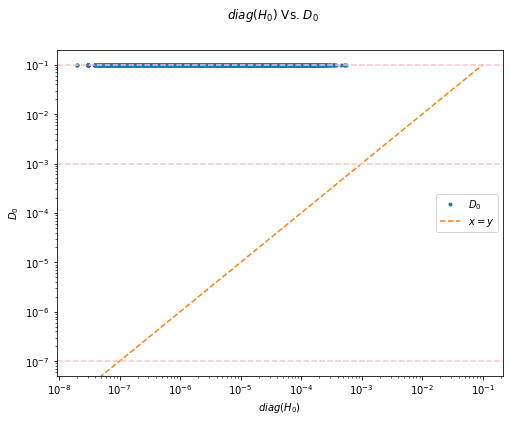

In [54]:
D = np.maximum(np.abs(Ds[-1]), 1e-1)
plot_hessian_acc(D, H_diag)

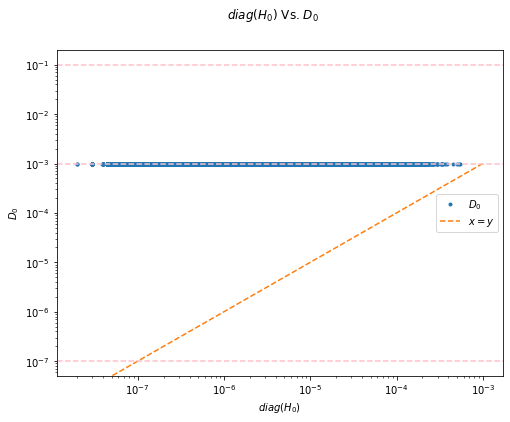

In [55]:
D = np.maximum(np.abs(Ds[-1]), 1e-3)
plot_hessian_acc(D, H_diag)

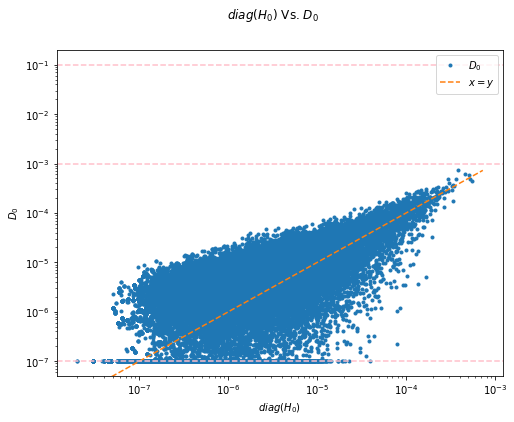

In [56]:
D = np.maximum(np.abs(Ds[-1]), 1e-7)
plot_hessian_acc(D, H_diag)

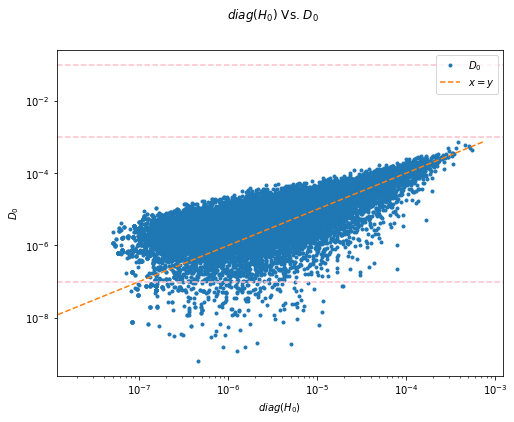

In [57]:
D = Ds[-1]
plot_hessian_acc(D, H_diag)

### Relative error

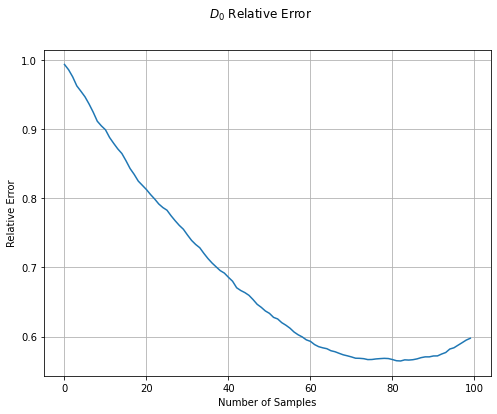

In [58]:
D_errors = rel_error(Ds, H_diag)
plot_hessian_approx(D_errors)

### Other datasets

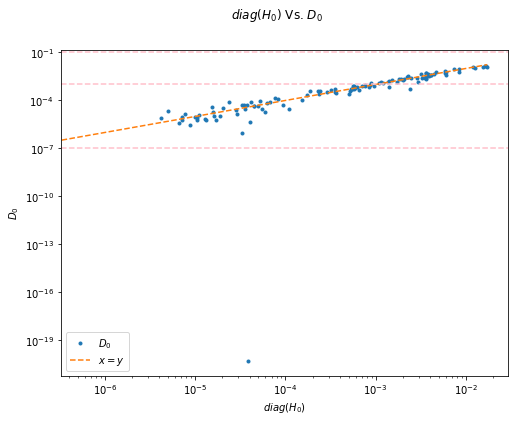

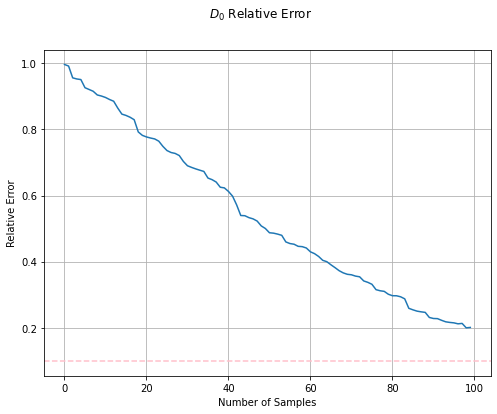

In [111]:
X, y = get_processed_data("datasets/a9a", corrupt=None)
Ds, H_diag = init_D(X, y, BS=128, warmup=100, zsamples=1, loss="logistic")
D = Ds[-1]
plot_hessian_acc(D, H_diag)
D_errors = rel_error(Ds, H_diag)
plot_hessian_approx(D_errors)

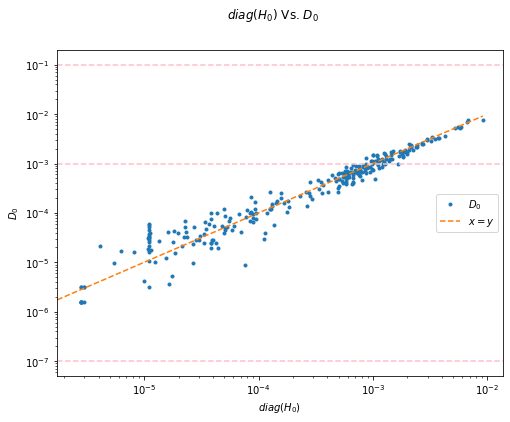

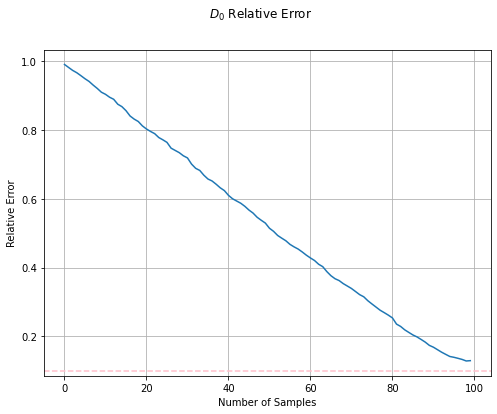

In [112]:
X, y = get_processed_data("datasets/w8a", corrupt=None)
Ds, H_diag = init_D(X, y, BS=128, warmup=100, zsamples=1, loss="logistic")
D = Ds[-1]
plot_hessian_acc(D, H_diag)
D_errors = rel_error(Ds, H_diag)
plot_hessian_approx(D_errors)

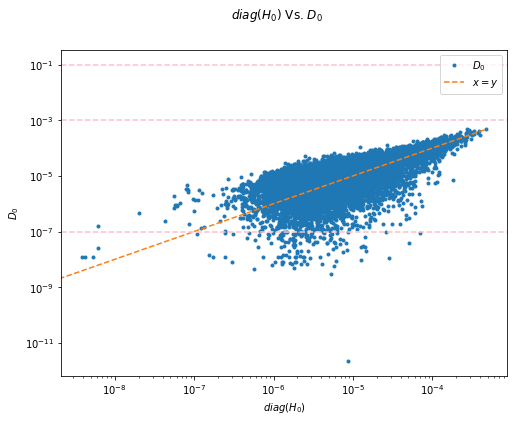

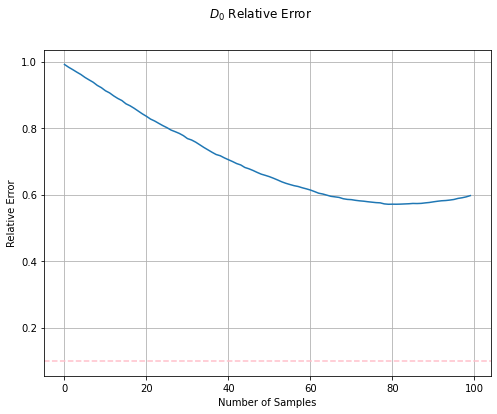

In [113]:
X, y = get_processed_data("datasets/real-sim", corrupt=None)
Ds, H_diag = init_D(X, y, BS=128, warmup=100, zsamples=1, loss="logistic")
D = Ds[-1]
plot_hessian_acc(D, H_diag)
D_errors = rel_error(Ds, H_diag)
plot_hessian_approx(D_errors)

### Increase warmup

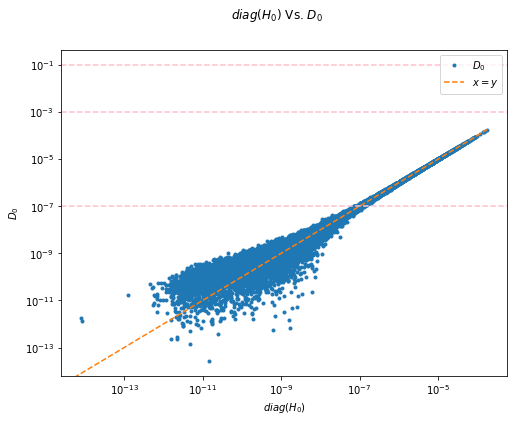

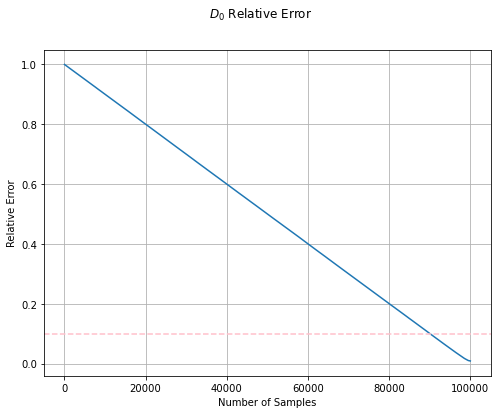

In [11]:
X, y = get_processed_data("datasets/real-sim", corrupt=(-3,0))
Ds, H_diag = init_D(X, y, BS=128, warmup=100000, zsamples=1, loss="logistic")
D = Ds[-1]
plot_hessian_acc(D, H_diag)
D_errors = rel_error(Ds, H_diag)
plot_hessian_approx(D_errors)

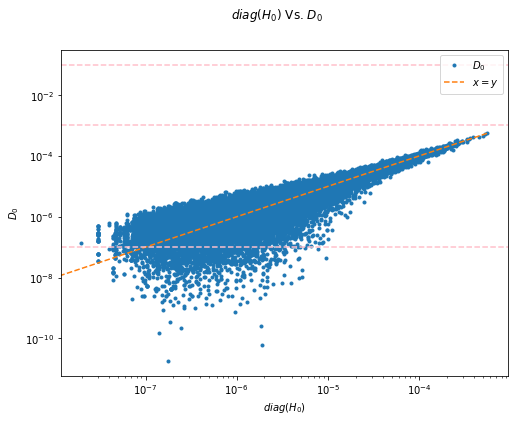

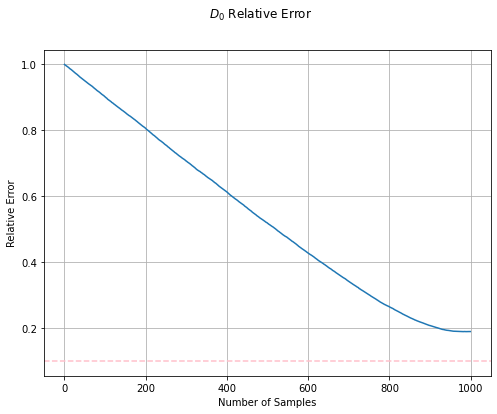

In [62]:
X, y = get_processed_data("datasets/rcv1", corrupt=None)
Ds, H_diag = init_D(X, y, BS=128, warmup=1000, zsamples=1, loss="logistic")
D = Ds[-1]
plot_hessian_acc(D, H_diag)
D_errors = rel_error(Ds, H_diag)
plot_hessian_approx(D_errors)

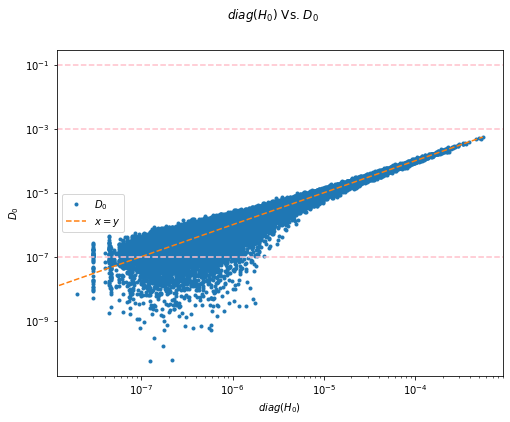

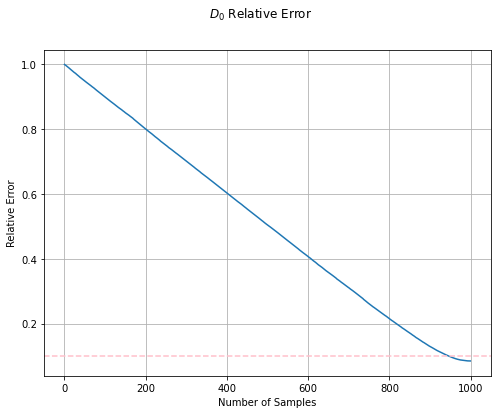

In [63]:
X, y = get_processed_data("datasets/rcv1", corrupt=None)
Ds, H_diag = init_D(X, y, BS=1024, warmup=1000, zsamples=1, loss="logistic")
D = Ds[-1]
plot_hessian_acc(D, H_diag)
D_errors = rel_error(Ds, H_diag)
plot_hessian_approx(D_errors)

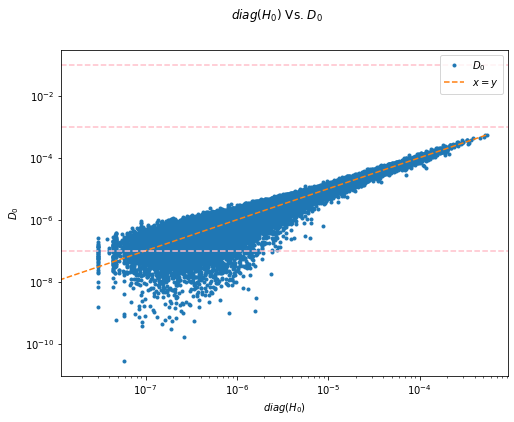

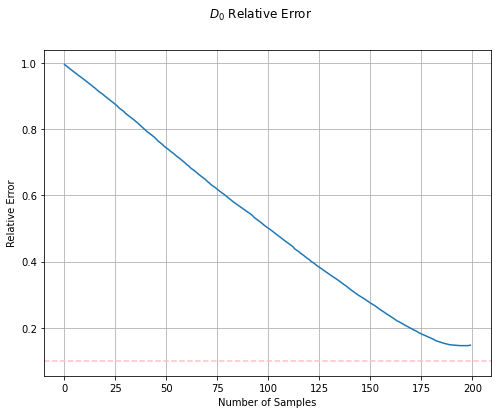

In [64]:
X, y = get_processed_data("datasets/rcv1", corrupt=None)
Ds, H_diag = init_D(X, y, BS=5000, warmup=200, zsamples=1, loss="logistic")
D = Ds[-1]
plot_hessian_acc(D, H_diag)
D_errors = rel_error(Ds, H_diag)
plot_hessian_approx(D_errors)

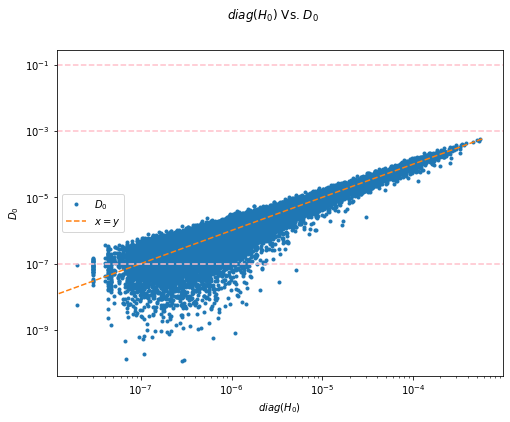

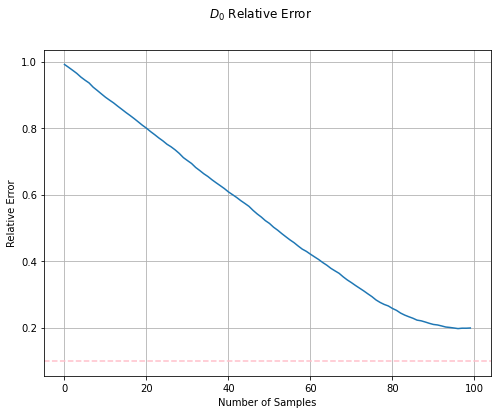

In [77]:
X, y = get_processed_data("datasets/rcv1", corrupt=None)
Ds, H_diag = init_D(X, y, BS=X.shape[0], warmup=100, zsamples=1, loss="logistic")
D = Ds[-1]
plot_hessian_acc(D, H_diag)
D_errors = rel_error(Ds, H_diag)
plot_hessian_approx(D_errors)

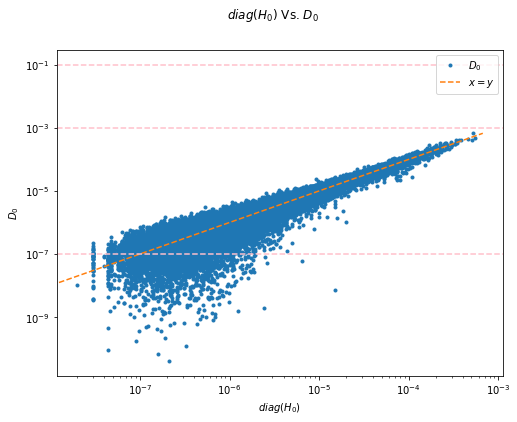

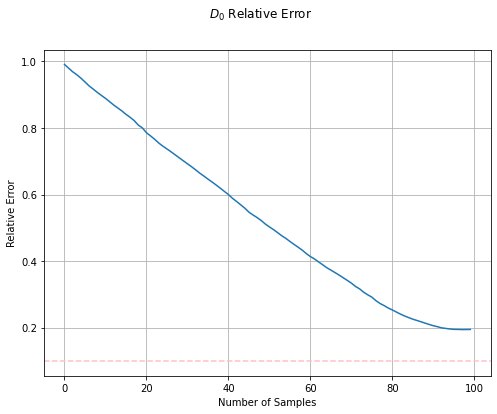

In [124]:
X, y = get_processed_data("datasets/rcv1", corrupt=None)
Ds, H_diag = init_D(X, y, BS=X.shape[0], warmup=10, zsamples=10, loss="logistic")
D = Ds[-1]
plot_hessian_acc(D, H_diag)
D_errors = rel_error(Ds, H_diag)
plot_hessian_approx(D_errors)

### Compare with nllsq loss

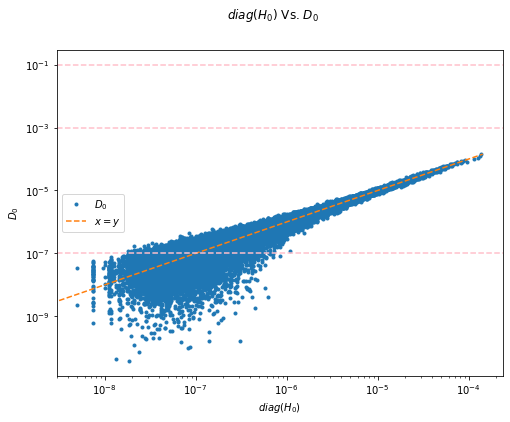

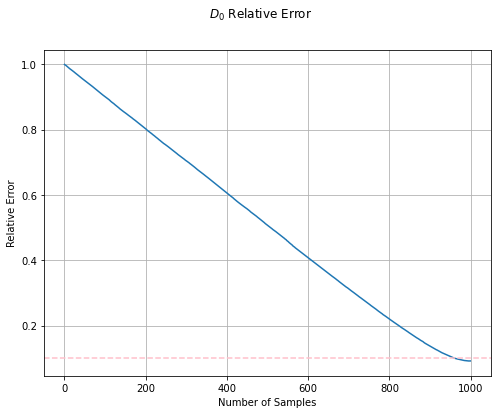

In [81]:
X, y = get_processed_data("datasets/rcv1", corrupt=None)
Ds, H_diag = init_D(X, y, BS=1024, warmup=1000, zsamples=1, loss="nllsq")
D = Ds[-1]
plot_hessian_acc(D, H_diag)
D_errors = rel_error(Ds, H_diag)
plot_hessian_approx(D_errors)

## Show relative errors for different settings

In [144]:
%%time

warmup = 300
num_seeds = 3

errors_df = pd.DataFrame()
for seed in range(num_seeds):
    for loss in LOSSES:
        for dataset in DATASETS:
            for corrupt in [None, (-3, 0), (0,3), (-3,3)]:
                for BS in [32, 128, 1024]:
                    np.random.seed(seed)
                    X, y = get_processed_data(f"datasets/{dataset}", corrupt=corrupt)
                    Ds, H_diag = init_D(X, y, BS=BS, warmup=warmup, zsamples=1)
                    df = pd.DataFrame()
                    df["error"] = rel_error(Ds, H_diag)
                    df["samples"] = np.array(list(range(warmup)))
                    df["seed"] = seed
                    df["loss"] = loss
                    df["dataset"] = dataset
                    df["corrupt"] = str(corrupt)
                    df["BS"] = BS
                    errors_df = errors_df.append(df)

errors_df = errors_df.reset_index()
errors_df

index     error  samples  seed       loss   dataset  corrupt    BS
0          0  0.999181        0     0   logistic       a9a     None    32
1          1  0.996400        1     0   logistic       a9a     None    32
2          2  0.995255        2     0   logistic       a9a     None    32
3          3  0.994681        3     0   logistic       a9a     None    32
4          4  0.993751        4     0   logistic       a9a     None    32
...      ...       ...      ...   ...        ...       ...      ...   ...
86395    295  0.051002      295     2  nonlinear  real-sim  (-3, 3)  1024
86396    296  0.050620      296     2  nonlinear  real-sim  (-3, 3)  1024
86397    297  0.050723      297     2  nonlinear  real-sim  (-3, 3)  1024
86398    298  0.050893      298     2  nonlinear  real-sim  (-3, 3)  1024
86399    299  0.050922      299     2  nonlinear  real-sim  (-3, 3)  1024

[86400 rows x 8 columns]

In [145]:
def plot_hessian_error(errors_df, dataset="a9a", loss="logistic", title=r"$D_0$ Relative Error", fname=None):
    fig = plt.figure()
    fig.set_size_inches(8, 6)
    plt.suptitle(rf"{title} ($\tt {dataset}, {loss} $)")
    error_plot_df = errors_df[
        (errors_df["dataset"] == dataset) &
        (errors_df["loss"] == loss)
    ]
    sns.lineplot(x="samples", y="error", hue="corrupt", style="BS", data=error_plot_df.iloc[::5])
    plt.ylabel(r"Relative Error")
    plt.xlabel(r"Number of Samples")
    plt.grid()
    plt.axhline(0.1, color="pink", linestyle="--")
    plt.axvline(100, color="pink", linestyle="--")
    if fname is not None:
        plt.savefig(fname)
    else:
        plt.show()
    plt.close()

In [146]:
dataset = "rcv1"
loss = "logistic"
plot_hessian_error(errors_df, dataset=dataset, loss=loss, fname=fr"rel_error({dataset},{loss}).pdf")

Plotting lines for (a9a,logistic)...
Plotting lines for (w8a,logistic)...
Plotting lines for (rcv1,logistic)...
Plotting lines for (real-sim,logistic)...


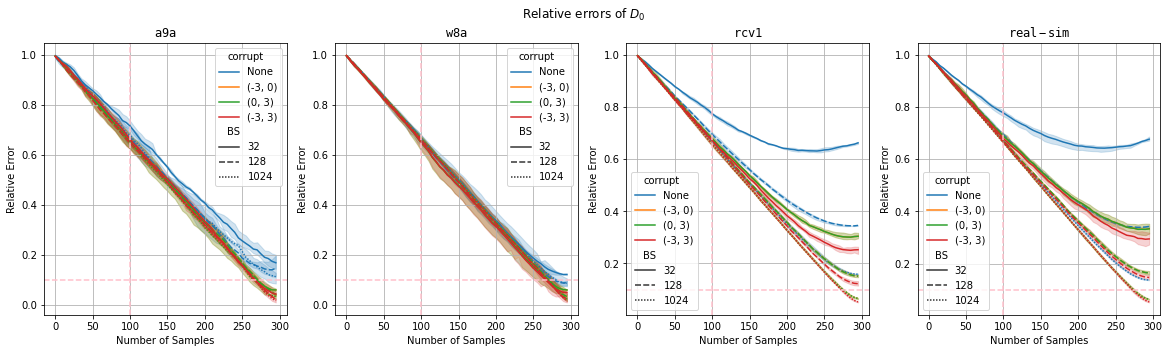

In [108]:

fig, axes = plt.subplots(1, len(DATASETS))
fig.set_size_inches(5 * len(DATASETS), 5)
plt.suptitle(rf"Relative errors of $D_0$")
for i, loss in enumerate(["logistic"]):
    for j, dataset in enumerate(DATASETS):
        print(f"Plotting lines for ({dataset},{loss})...")
        error_plot_df = errors_df[
            (errors_df["dataset"] == dataset) &
            (errors_df["loss"] == loss)
        ]
        sns.lineplot(x="samples", y="error", hue="corrupt", style="BS",
                     ax=axes[j], data=error_plot_df.iloc[::5])
        axes[j].set_title(fr"$\tt {dataset} $")
        axes[j].set_ylabel("Relative Error")
        axes[j].set_xlabel(r"Number of Samples")
        axes[j].grid()
        axes[j].axhline(0.1, color="pink", linestyle="--")
        axes[j].axvline(100, color="pink", linestyle="--")
plt.savefig(fr"plots/rel_errors(dataset={dataset},loss={loss}).pdf")

## Plot est. diagonal vs. true diagonal for different batch sizes and warmup periods

In [147]:
%%time

num_seeds = 1
BSs = [32, 128, 1024]
warmups = [100, 250, 1000]

diagonals_df = pd.DataFrame()
for seed in range(num_seeds):
    for loss in LOSSES:
        for dataset in DATASETS:
            for corrupt in [None, (-3,3)]:
                for BS in BSs:
                    for warmup in warmups:
                        np.random.seed(seed)
                        X, y = get_processed_data(f"datasets/{dataset}", corrupt=corrupt)
                        Ds, H_diag = init_D(X, y, BS=BS, warmup=warmup, zsamples=1)
                        df = pd.DataFrame()
                        df["D"] = Ds[-1]
                        df["H_diag"] = H_diag
                        df["warmup"] = warmup
                        df["seed"] = seed
                        df["loss"] = loss
                        df["dataset"] = dataset
                        df["corrupt"] = str(corrupt)
                        df["BS"] = BS
                        diagonals_df = diagonals_df.append(df)

diagonals_df = diagonals_df.reset_index()
diagonals_df

CPU times: user 1min 1s, sys: 3.85 s, total: 1min 5s
Wall time: 1min 17s


index             D        H_diag  warmup  seed       loss   dataset  \
0            0  3.255638e-03  3.580302e-03     100     0   logistic       a9a   
1            1  3.524783e-03  3.246119e-03     100     0   logistic       a9a   
2            2  2.979507e-03  3.766990e-03     100     0   logistic       a9a   
3            3  2.663261e-03  3.516229e-03     100     0   logistic       a9a   
4            4  3.285048e-03  3.940641e-03     100     0   logistic       a9a   
...        ...           ...           ...     ...   ...        ...       ...   
2470207  20953  7.312627e-04  6.552612e-05    1000     0  nonlinear  real-sim   
2470208  20954  4.646740e-01  4.847704e-01    1000     0  nonlinear  real-sim   
2470209  20955  4.371019e-05  8.175788e-07    1000     0  nonlinear  real-sim   
2470210  20956  3.603738e-04  4.096014e-06    1000     0  nonlinear  real-sim   
2470211  20957  5.068569e-07  4.971052e-11    1000     0  nonlinear  real-sim   

         corrupt    BS  
0           None    32  
1           None    32  
2           None    32  
3           None    32  
4           None    32  
...          ...   ...  
2470207  (-3, 3)  1024  
2470208  (-3, 3)  1024  
2470209  (-3, 3)  1024  
2470210  (-3, 3)  1024  
2470211  (-3, 3)  1024  

[2470212 rows x 9 columns]

CPU times: user 39 s, sys: 69.9 ms, total: 39.1 s
Wall time: 39.1 s


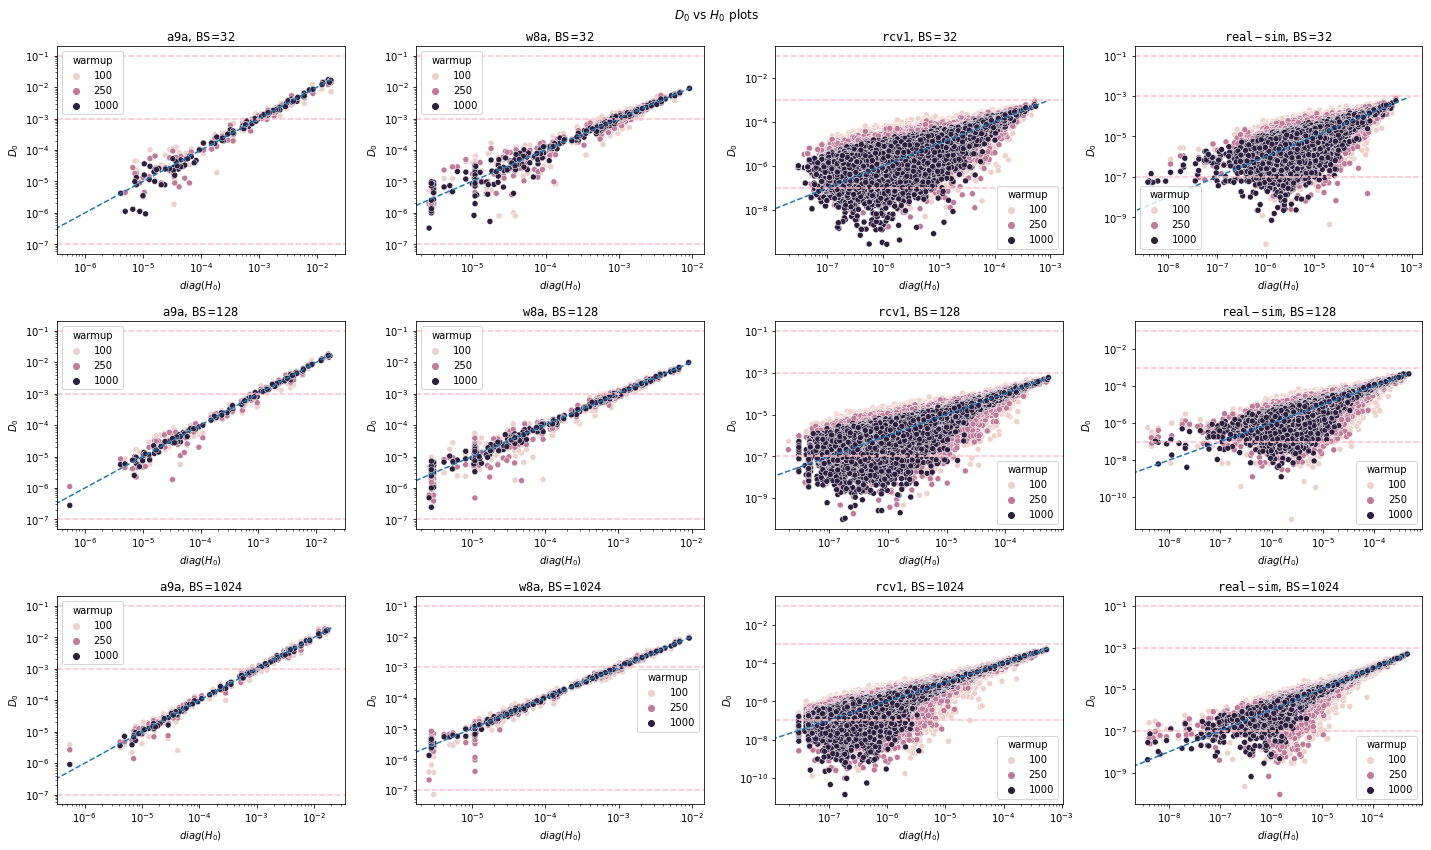

In [202]:
%%time

loss = "logistic"
corrupt = None  # (-3,3)

diagonals_df_min = diagonals_df[
    (diagonals_df["loss"] == loss) &
    (diagonals_df["corrupt"] == str(corrupt))
]

fig, axes = plt.subplots(3, 4)
fig.set_size_inches(20, 12)
plt.suptitle(rf"$D_0$ vs $H_0$ plots")
for i, BS in enumerate(BSs):
    for j, dataset in enumerate(DATASETS):
        df = diagonals_df_min[
            (diagonals_df_min["dataset"] == dataset) &
            (diagonals_df_min["BS"] == BS)
        ]
        sns.scatterplot(y="D", x="H_diag", hue="warmup", hue_norm=LogNorm(),
                        ax=axes[i,j], data=df)
        axes[i,j].set_yscale("log")
        axes[i,j].set_xscale("log")

        lim = df[["D", "H_diag"]].max().max()
        axes[i,j].plot([0, lim], [0, lim], '--', label=r"$x=y$")
        axes[i,j].axhline(y=10**-1, color='pink', linestyle='--')
        axes[i,j].axhline(y=10**-3, color='pink', linestyle='--')
        axes[i,j].axhline(y=10**-7, color='pink', linestyle='--')
        axes[i,j].set_title(fr"$\tt {dataset} $, $\tt BS = {BS}$")
        axes[i,j].set_xlabel(r"$diag(H_0)$")
        axes[i,j].set_ylabel(r"$D_0$")
        # axes[i,j].grid()
plt.tight_layout()
plt.savefig(fr"plots/diagonals(loss={loss},corrupt={corrupt}).pdf")

## Animate plots

In [8]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animate_hessian_acc(H_diag, Ds, title=r"$diag(H_0)$ Vs. $D_0$", fname=None):
    D = Ds[0]
    fig = plt.figure()
    fig.set_size_inches(8, 6)
    plt.suptitle(title)
    line, = plt.loglog(H_diag, D, '.', label=r"$D_0$")
    lim = max(H_diag.max(), D.max())
    plt.plot([0, lim], [0, lim], '--', label=r"$x=y$")
    plt.xlabel(r"$diag(H_0)$")
    plt.ylabel(r"$D_0$")
    plt.axhline(y=10**-1, color='pink', linestyle='--')
    plt.axhline(y=10**-3, color='pink', linestyle='--')
    plt.axhline(y=10**-7, color='pink', linestyle='--')
    plt.legend()

    def animate(i):
        line.set_ydata(Ds[i])  # update the data.
        return line,
    ani = FuncAnimation(fig, animate, interval=20, blit=True,
                        save_count=min(Ds.shape[0], 100))

    if fname is not None:
        ani.save(fname)
        plt.close()
    else:
        plt.close()
        return HTML(ani.to_html5_video())



In [9]:
animate_hessian_acc(H_diag, Ds)

## Experiment around

In [177]:
X, y = get_processed_data("datasets/a9a", corrupt=None)
Ds, H_diag = init_D(X, y, BS=16, warmup=100, zsamples=1)
animate_hessian_acc(H_diag, np.maximum(np.abs(Ds), 1e-7))

In [178]:
X, y = get_processed_data("datasets/a9a", corrupt=None)
Ds, H_diag = init_D(X, y, BS=16, warmup=100, zsamples=4)
animate_hessian_acc(H_diag, np.maximum(np.abs(Ds), 1e-7))

In [179]:
X, y = get_processed_data("datasets/a9a", corrupt=None)
Ds, H_diag = init_D(X, y, BS=4, warmup=100, zsamples=4)
animate_hessian_acc(H_diag, np.maximum(np.abs(Ds), 1e-7))

In [180]:
X, y = get_processed_data("datasets/a9a", corrupt=None)
Ds, H_diag = init_D(X, y, BS=32, warmup=50, zsamples=1)
animate_hessian_acc(H_diag, np.maximum(np.abs(Ds), 1e-7))

In [181]:
X, y = get_processed_data("datasets/a9a", corrupt=None)
Ds, H_diag = init_D(X, y, BS=2048, warmup=100, zsamples=1)
animate_hessian_acc(H_diag, np.maximum(np.abs(Ds), 1e-7))

Bigger batch sizes clearly help, and warmup less so. But more z samples seem to degrade accuracy. Why? (Because bias?)

### Experiment with other datasets and feature scaling

In [186]:
X, y = get_processed_data("datasets/w8a", corrupt=None)
Ds, H_diag = init_D(X, y, BS=512, warmup=100, zsamples=1)
animate_hessian_acc(H_diag, Ds)

In [185]:
X, y = get_processed_data("datasets/rcv1", corrupt=None)
Ds, H_diag = init_D(X, y, BS=512, warmup=100, zsamples=1)
animate_hessian_acc(H_diag, Ds)

In [187]:
X, y = get_processed_data("datasets/real-sim", corrupt=None)
Ds, H_diag = init_D(X, y, BS=512, warmup=100, zsamples=1)
animate_hessian_acc(H_diag, Ds)

### Feature scaling

In [188]:
X, y = get_processed_data("datasets/real-sim", corrupt=(0,3))
Ds, H_diag = init_D(X, y, BS=512, warmup=100, zsamples=1)
animate_hessian_acc(H_diag, Ds)

In [189]:
X, y = get_processed_data("datasets/real-sim", corrupt=(-3,0))
Ds, H_diag = init_D(X, y, BS=512, warmup=100, zsamples=1)
animate_hessian_acc(H_diag, Ds)

In [190]:
X, y = get_processed_data("datasets/real-sim", corrupt=(0,10))
Ds, H_diag = init_D(X, y, BS=512, warmup=100, zsamples=1)
animate_hessian_acc(H_diag, Ds)

In [191]:
X, y = get_processed_data("datasets/real-sim", corrupt=(-10,0))
Ds, H_diag = init_D(X, y, BS=512, warmup=100, zsamples=1)
animate_hessian_acc(H_diag, Ds)

In [193]:
X, y = get_processed_data("datasets/real-sim", corrupt=(-3,3))
Ds, H_diag = init_D(X, y, BS=512, warmup=1000, zsamples=1)
animate_hessian_acc(H_diag, Ds)

In [194]:
X, y = get_processed_data("datasets/real-sim", corrupt=(-10,10))
Ds, H_diag = init_D(X, y, BS=512, warmup=1000, zsamples=1)
animate_hessian_acc(H_diag, Ds)

In [195]:
X, y = get_processed_data("datasets/real-sim", corrupt=(-10,10))
Ds, H_diag = init_D(X, y, BS=2048, warmup=1000, zsamples=1)
animate_hessian_acc(H_diag, Ds)

In [196]:
X, y = get_processed_data("datasets/real-sim", corrupt=(-10,10))
Ds, H_diag = init_D(X, y, BS=128, warmup=1000, zsamples=1)
animate_hessian_acc(H_diag, Ds)

In [197]:
X, y = get_processed_data("datasets/real-sim", corrupt=(-10,10))
Ds, H_diag = init_D(X, y, BS=2048, warmup=1000, zsamples=5)
animate_hessian_acc(H_diag, Ds)

In [198]:
X, y = get_processed_data("datasets/real-sim", corrupt=(-10,10))
Ds, H_diag = init_D(X, y, BS=2048, warmup=1000, zsamples=20)
animate_hessian_acc(H_diag, Ds)

### kde

/Users/zelig/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


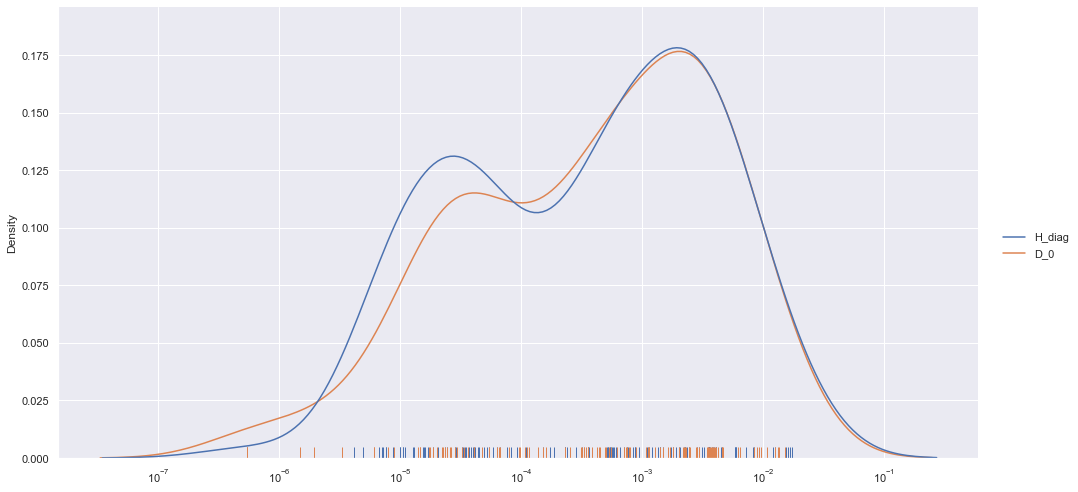

In [240]:
X, y = get_processed_data("datasets/a9a", corrupt=(0,0))
Ds, H_diag = init_D(X, y, BS=128, warmup=100, zsamples=1)
df = {"H_diag": H_diag, "D_0": Ds[-1]+H_diag.min()}
_ = sns.displot(df, kind="kde", log_scale=True, rug=True, height=7, aspect=2)

/Users/zelig/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


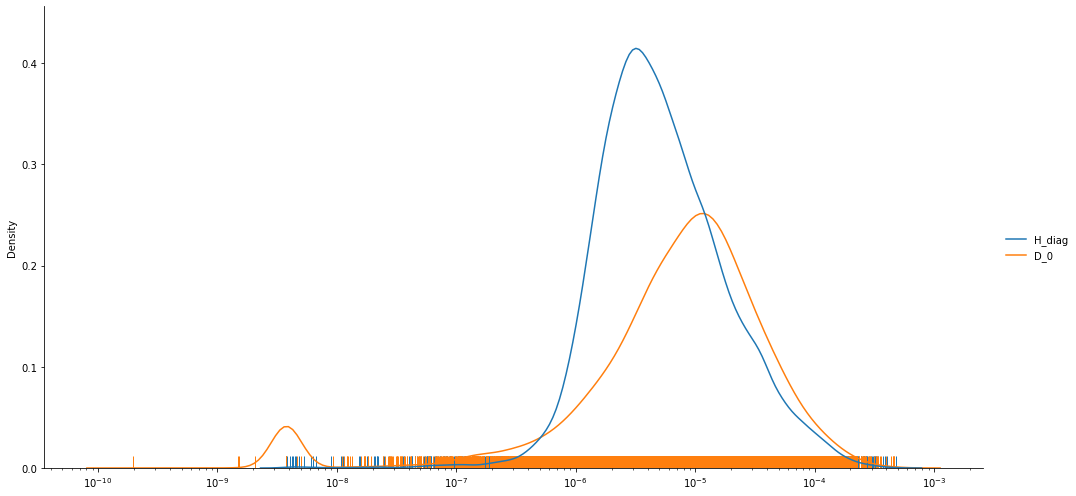

In [25]:
X, y = get_processed_data("datasets/real-sim", corrupt=(0,0))
Ds, H_diag = init_D(X, y, BS=128, warmup=100, zsamples=1)
df = {"H_diag": H_diag, "D_0": Ds[-1]+H_diag.min()}
_ = sns.displot(df, kind="kde", log_scale=True, rug=True, height=7, aspect=2)

/Users/zelig/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


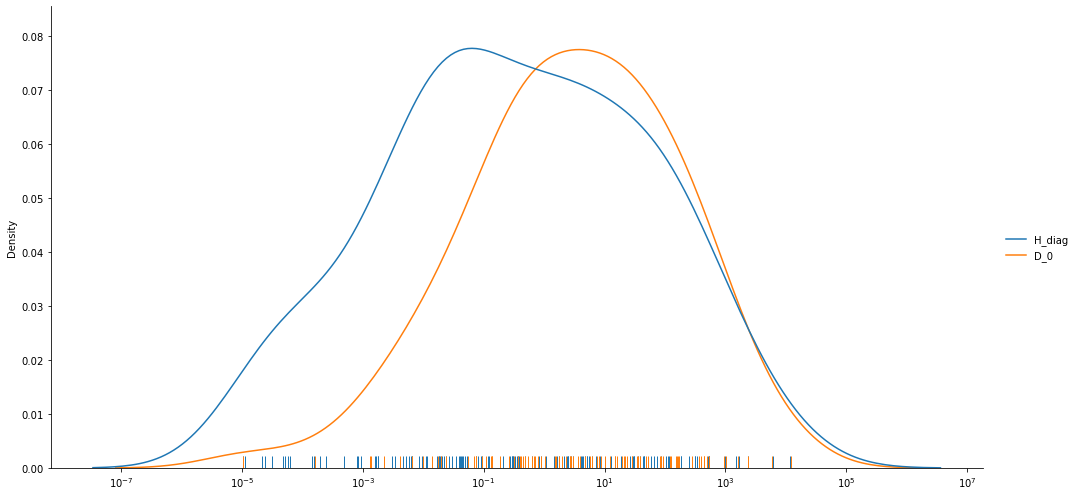

In [24]:
X, y = get_processed_data("datasets/a9a", corrupt=(0,3))
Ds, H_diag = init_D(X, y, BS=128, warmup=100, zsamples=1)
df = {"H_diag": H_diag, "D_0": Ds[-1]+H_diag.min()}
_ = sns.displot(df, kind="kde", log_scale=True, rug=True, height=7, aspect=2)

/Users/zelig/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


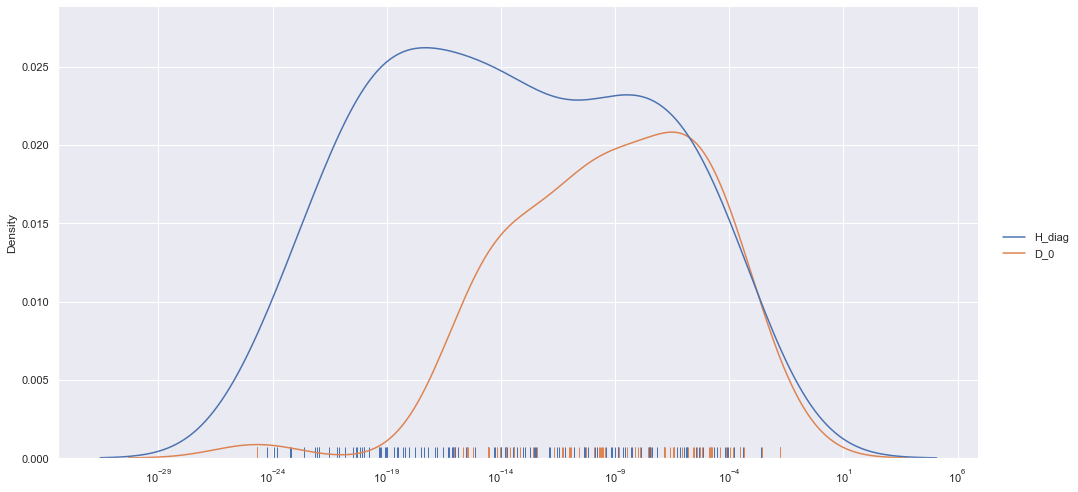

In [244]:
X, y = get_processed_data("datasets/a9a", corrupt=(-10,0))
Ds, H_diag = init_D(X, y, BS=128, warmup=100, zsamples=1)
df = {"H_diag": H_diag, "D_0": Ds[-1]+H_diag.min()}
_ = sns.displot(df, kind="kde", log_scale=True, rug=True, height=7, aspect=2)

/Users/zelig/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


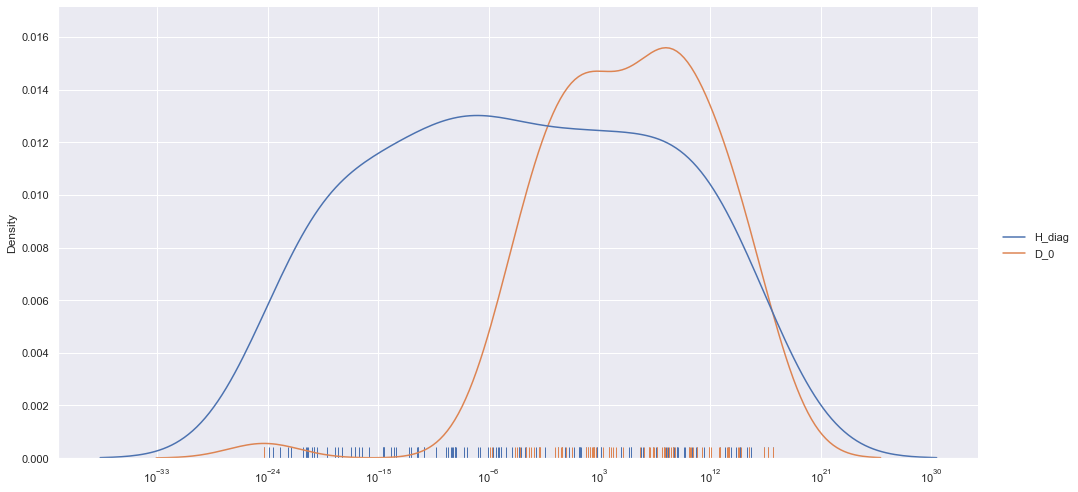

In [246]:
X, y = get_processed_data("datasets/a9a", corrupt=(-10,10))
Ds, H_diag = init_D(X, y, BS=128, warmup=100, zsamples=1)
df = {"H_diag": H_diag, "D_0": Ds[-1]+H_diag.min()}
_ = sns.displot(df, kind="kde", log_scale=True, rug=True, height=7, aspect=2)